In [1]:
import os
import pandas as pd
import seaborn as sns

import numpy as np

from matplotlib import pyplot as plt
import matplotlib as mpl

import scipy
import scipy.stats as stats

In [17]:
# constants
MAX_VELOCITY = 5.0
LABEL_COLOR = "black"
TICK_COLOR = "black"
FONT_SIZE = 14

# general
mpl.rcParams["text.color"] = LABEL_COLOR
mpl.rcParams["font.family"] = "monospace"
mpl.rcParams["font.size"] = FONT_SIZE
mpl.rcParams["font.style"] = "italic"
mpl.rcParams["font.weight"] = "light"

# label
mpl.rcParams["axes.labelcolor"] = LABEL_COLOR
mpl.rcParams["axes.labelsize"] = FONT_SIZE
mpl.rcParams["axes.labelweight"] = "light"

# ticks
mpl.rcParams["xtick.color"] = TICK_COLOR
mpl.rcParams["ytick.color"] = TICK_COLOR
mpl.rcParams["xtick.labelsize"] = FONT_SIZE
mpl.rcParams["ytick.labelsize"] = FONT_SIZE

In [18]:
def heatmap(evaluation_results: pd.DataFrame, target_velocities: np.ndarray, delta: float = 0.25):
    evaluation_results_list = evaluation_results.to_dict("records")
    heatmap_values = list()

    for i in range(len(target_velocities) - 1):
        heatmap_values.append({
            "target_velocity": target_velocities[i],
            "stub_y": 1.0,
            "r": 0.0
        })

    for i in range(len(heatmap_values)):
        velocity_min = heatmap_values[i]["target_velocity"]
        velocity_max = velocity_min + delta

        rewards = list()
        for j in range(len(evaluation_results_list)):
            target_velocity = evaluation_results_list[j]["target_velocity"]
            r_eval = evaluation_results_list[j]["r"]

            if (velocity_min <= target_velocity < velocity_max):
                rewards.append(r_eval)
                pass

        heatmap_values[i]["r"] = np.mean(rewards)
    
    heatmap_values_df = pd.DataFrame.from_dict(heatmap_values)
    heatmap_values_df["target_velocity"] = heatmap_values_df["target_velocity"] 

    heatmap = heatmap_values_df.pivot(index="stub_y", columns=["target_velocity"], values="r")
    heatmap.sort_index(ascending=False, inplace=True)

    return heatmap

In [19]:
def merge_csvs_to_df(csv_paths: list) -> pd.DataFrame:
    merged_data = list()

    for csv in csv_paths: 
        temp = pd.read_csv(csv).to_dict("records")
        merged_data.extend(temp)
        pass

    return pd.DataFrame.from_records(merged_data)

In [20]:
# constants
random_seeds = [2878, 5069, 5073, 5250, 4420]
target_velocities = np.linspace(0.0, MAX_VELOCITY, num=21)
delta = target_velocities[1] - target_velocities[0]

In [21]:
rl_squared_csvs = list()
auto_dr_csvs = list()

for seed in random_seeds:
    rl_squared_csvs.append(f"../data/rl_squared/max-{int(MAX_VELOCITY)}/seed-{seed}.csv")
    auto_dr_csvs.append(f"../data/auto_dr/max-{int(MAX_VELOCITY)}/seed-{seed}.csv")
    pass

In [22]:
rl_squared_results = merge_csvs_to_df(rl_squared_csvs)

# merge
rl_squared_data = list()
for csv in rl_squared_csvs:
    temp = pd.read_csv(csv).to_dict("records")
    rl_squared_data.extend(temp)

In [23]:
auto_dr_results = merge_csvs_to_df(auto_dr_csvs)

# merge
auto_dr_data = list()
for csv in auto_dr_csvs:
    temp = pd.read_csv(csv).to_dict("records")
    auto_dr_data.extend(temp)

In [24]:
rl_squared_results = pd.DataFrame.from_records(rl_squared_data)
rl_squared_results["target_velocity"] = rl_squared_results["target_velocity"].str.removesuffix("]")
rl_squared_results["target_velocity"] = rl_squared_results["target_velocity"].str.removeprefix("[")
rl_squared_results["target_velocity"] = rl_squared_results["target_velocity"].astype(float)

auto_dr_results = pd.DataFrame.from_records(auto_dr_data)
auto_dr_results["target_velocity"] = auto_dr_results["target_velocity"].str.removesuffix("]")
auto_dr_results["target_velocity"] = auto_dr_results["target_velocity"].str.removeprefix("[")
auto_dr_results["target_velocity"] = auto_dr_results["target_velocity"].astype(float)

In [25]:
def significance_heatmap(
    rl2_results: pd.DataFrame, 
    rl2_adr_results: pd.DataFrame, 
    target_velocities: np.ndarray, 
    delta: float = 0.25
):
    heatmap_values = list()

    for i in range(len(target_velocities) - 1):
        heatmap_values.append({
            "target_velocity": round(target_velocities[i], 2),
            "pdf_shift": 0.0,
            "stub_y": 1.0
        })

    # p-values
    rl2_results_list = rl2_results.to_dict("records")
    rl2_adr_results_list = rl2_adr_results.to_dict("records")

    for i in range(len(heatmap_values)):
        target_velocity_min = heatmap_values[i]["target_velocity"]
        target_velocity_max = target_velocity_min + delta

        # RL2
        rewards_rl2 = list()
        for j in range(len(rl2_results_list)):
            x_eval = rl2_results_list[j]["target_velocity"]
            r_eval = rl2_results_list[j]["r"]

            if (target_velocity_min <= x_eval < target_velocity_max):
                rewards_rl2.append(r_eval)
                pass

        # RL2-ADR
        rewards_rl2_adr = list()
        for j in range(len(rl2_adr_results_list)):
            x_eval = rl2_adr_results_list[j]["target_velocity"]
            r_eval = rl2_adr_results_list[j]["r"]

            if (target_velocity_min <= x_eval < target_velocity_max):
                rewards_rl2_adr.append(r_eval)
                pass

        # tests the null hypothesis that the population median of both groups is the same.
        p_value = stats.kruskal(rewards_rl2, rewards_rl2_adr).pvalue
        if p_value < 0.05:
            # if this is positive -> rl2-adr is better
            # if this is negative -> rl2 is better
            diff_normalized = (np.median(rewards_rl2_adr) - np.median(rewards_rl2)) / abs(np.median(rewards_rl2_adr))
        else:
            # stub, distributions are the same.
            diff_normalized = 0.0

        heatmap_values[i]["pdf_shift"] = diff_normalized
        continue

    heatmap_values_df = pd.DataFrame.from_dict(heatmap_values)
    heatmap_values_df["target_velocity"] = heatmap_values_df["target_velocity"]

    heatmap = heatmap_values_df.pivot(index="stub_y", columns=["target_velocity"], values="pdf_shift")
    heatmap.sort_index(ascending=False, inplace=True)

    return heatmap, heatmap_values_df

In [26]:
pdf_shift_heatmap, heatmap_values_df = significance_heatmap(
    rl_squared_results, 
    auto_dr_results,
    target_velocities,  
    delta
)

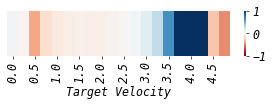

In [27]:
plt.figure(figsize = (6, 1), dpi=60)

new_columns = list()
for col in pdf_shift_heatmap.columns:
    new_columns.append(str(round(float(col), 2)))

pdf_shift_heatmap.columns = new_columns

ax = sns.heatmap(
    pdf_shift_heatmap,
    cmap=sns.color_palette("RdBu", as_cmap=True),
    vmin=-1.0,
    vmax=1.0
)

ax.set(xlabel="Target Velocity", ylabel="")
ax.get_yaxis().set_ticks([])
plt.xticks(rotation=90)
plt.show()

In [28]:
# ood
ood_rewards_data = pd.DataFrame()
ood_rewards_data["RL2"] = rl_squared_results[rl_squared_results["target_velocity"] > 3.0]["r"]
ood_rewards_data["RL2-ADR"] = auto_dr_results[auto_dr_results["target_velocity"] > 3.0]["r"]

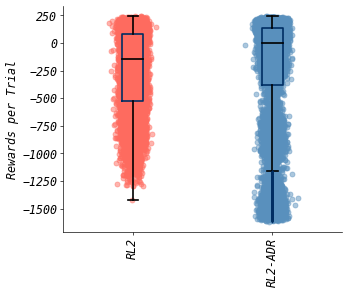

In [29]:
# boxplot
vals, names, xs = [],[],[]

for i, col in enumerate(ood_rewards_data.columns):
    vals.append(ood_rewards_data[col].values)
    names.append(col)
    # adds jitter to the data points - can be adjusted
    xs.append(np.random.normal(i + 1, 0.04, ood_rewards_data[col].values.shape[0]))
    continue

fig = plt.figure(figsize = (6, 5), dpi=60)
ax  = fig.add_subplot(111)

box_plot = ax.boxplot(
    vals, 
    labels=names, 
    whiskerprops={'linewidth': 2},    
    capprops={'linewidth': 2},
    boxprops={'color':'#002e63', 'linewidth': 2},
    flierprops={'marker': 'o', 'linewidth': 2, 'markersize': 1, 'markerfacecolor': 'none', 'markeredgecolor':'#002e63'},
    medianprops={'linewidth': 2, 'color':'black'}
)

palette = ['#fe6b5f', '#5990bd']

for x, val, c in zip(xs, vals, palette):
    plt.scatter(x, val, alpha=0.5, color=c)
    continue


# label
ax.set_ylabel('Rewards per Trial')
ax.xaxis.label.set_color(LABEL_COLOR)
ax.yaxis.label.set_color(LABEL_COLOR)
plt.xticks(rotation=90)
sns.despine()
plt.show()

# format
plt.show()

In [31]:
stats.kruskal(ood_rewards_data["RL2"], ood_rewards_data["RL2-ADR"]).pvalue

3.576571639454623e-97

In [30]:
np.median(ood_rewards_data["RL2"]), np.median(ood_rewards_data["RL2-ADR"])

(-143.25504125049403, 3.445377665434187)